In [1]:
# main
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import R2Score


# implementation
from tools import make_regression_data, RegressionDataset, finite_time_opt_training, plot_results
from optimizers import FiniteTimeOptimizer, DREMOptimizer

# graphics
import matplotlib.pyplot as plt


torch.random.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data

In [17]:
NUMBER_OF_FEATURES = 10
X_train, X_test, y_train, y_test = make_regression_data(number_samples=1000,
                                                        number_features=NUMBER_OF_FEATURES,
                                                        noise_value=15.5)
print(f'shape of train: {X_train.shape, y_train.shape}\nshape of test: {X_test.shape, y_test.shape}')

shape of train: (torch.Size([800, 10]), torch.Size([800, 1]))
shape of test: (torch.Size([200, 10]), torch.Size([200, 1]))


In [3]:
train_dataset = RegressionDataset(features=X_train,
                                  labels=y_train)
test_dataset = RegressionDataset(features=X_test,
                                 labels=y_test)
print(f'example of train sample:\n {train_dataset[19]}')

example of train sample:
 (tensor([-0.5173, -0.5229,  1.5796,  2.2989,  1.4534, -0.3628, -0.2818,  1.4093,
        -0.4455, -0.4202]), tensor([182.9647]))


In [18]:
BATCH_SIZE = 80

train_dataloader = DataLoader(dataset=train_dataset,
                              shuffle=True,
                              batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE)
batch_example_features, batch_example_labels  = next(iter(train_dataloader))
print('shape of batch: features - {} and labels - {}'.format(batch_example_features.shape, batch_example_labels.shape))

shape of batch: features - torch.Size([80, 10]) and labels - torch.Size([80, 1])


## Model

In [19]:
simple_model = nn.Linear(in_features=10, out_features=1, bias=False)

## Loss & metric & optimizer

In [20]:
loss_fn = nn.MSELoss()

metric_fn = R2Score()

N_OF_BATCHES = 2
optimizer = FiniteTimeOptimizer(params=simple_model.parameters(),
                                lr=0.01,
                                n_of_batches=N_OF_BATCHES)

## Train

In [21]:
n_epochs, loss_train, loss_test, score_test = finite_time_opt_training(model=simple_model,
                                                                       optimizer_fn=optimizer,
                                                                       loss_fn=loss_fn,
                                                                       metric_fn=metric_fn,
                                                                       data_train=train_dataloader,
                                                                       data_test=test_dataloader,
                                                                       learning_rate=1e-2,
                                                                       current_device="cpu",
                                                                       min_score=0.95,
                                                                       printed=True)

epoch 1: loss = 39443.164 and score = 0.347
epoch 2: loss = 14051.803 and score = 0.767
epoch 3: loss = 1458.183 and score = 0.976


## Test

In [22]:
with torch.inference_mode():
    metric, loss = 0.0, 0.0
    for X_batch, y_batch in test_dataloader:
        predicted = simple_model(X_batch)
        loss += loss_fn(predicted, y_batch)
        metric += metric_fn(predicted, y_batch)
    metric /= len(test_dataloader)
    loss /= len(test_dataloader)

    print(f"R2 = {metric:.3f}")
    print(f"loss = {loss:.3f}")

R2 = 0.976
loss = 1458.183


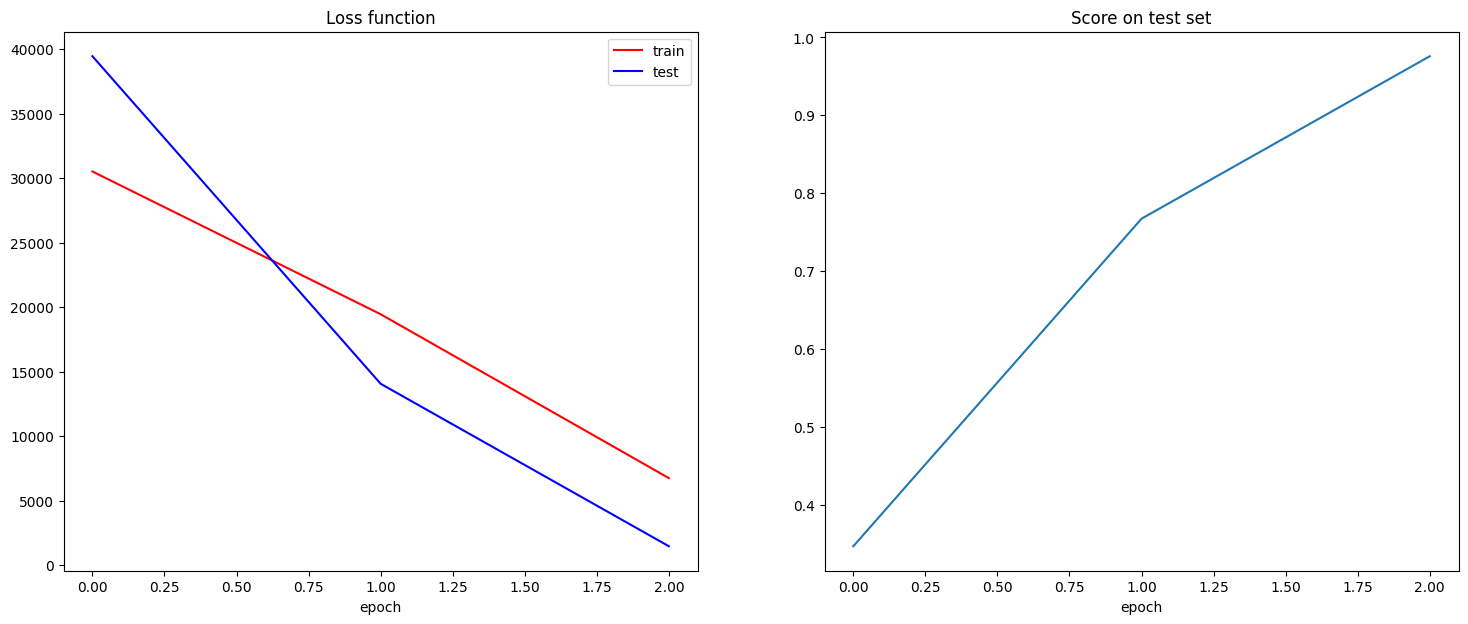

In [23]:
plot_results(loss_train, loss_test, score_test)